# Phase 4: Train DeepLab on Landcover.ai Dataset

**Goal**: Train DeepLab on real aerial imagery and match with the paper's performance

**Dataset**: Landcover.ai v1 (41 GeoTIFFs, 512×512 tiles, 5 land cover classes)


## 1: Setup and Imports

In [1]:
import sys
import os
import numpy as np
import random
import torchvision.transforms.functional as F
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import warnings

print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Device: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\nUsing device: {device}")

CLASS_NAMES = ['background', 'building', 'woodland', 'water', 'road']
NUM_CLASSES = len(CLASS_NAMES)

# Add augmentation imports
import torchvision.transforms.v2 as v2

#import tv_tensors
from torchvision import tv_tensors


class Rotate90Only(v2.Transform):
    def __init__(self):
        super().__init__()

    def _transform_image(self, img:torch.Tensor, k):
        """
        Rotate by k * 90 degrees losslessly using transpose + flip.
        Works for PIL, torch.Tensor, and tv_tensors.Image.
        """
        if k == 0:
            return img

        # img is CHW or HW for Mask
        hdim = -2
        wdim = -1
        
        if k == 1:   # 90°
            return img.transpose(hdim, wdim).flip(wdim)
        elif k == 2: # 180°
            return img.flip(hdim).flip(wdim)
        elif k == 3: # 270°
            return img.transpose(hdim, wdim).flip(hdim)
        else:
            return img

    def forward(self, img:torch.Tensor, mask=None):
        # choose k in {0,1,2,3}
        k = random.randint(0, 3)

        img = self._transform_image(img, k)

        if mask is not None:
            mask = self._transform_image(mask, k)

        if mask is None:
            return img
        return img, mask

# Create augmentation pipeline for training
train_augmentation = v2.Compose([
    v2.ToImage(),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomResizedCrop(size=512, scale=(0.8, 2.0), ratio=(0.9, 1.1)),
    Rotate90Only(),
])

print("✓ Augmentation pipeline created")

PyTorch: 2.9.1+cu130
CUDA available: True
Device: NVIDIA GeForce RTX 5090
Memory: 31.8 GB

Using device: cuda
✓ Augmentation pipeline created


## 2: Define Dataset Class

In [2]:
class LandcoverAIDataset(Dataset):
    """
    Load Landcover.ai dataset with 512x512 tile extraction.
    Supports online data augmentation for training.
    
    inputs:
        root_dir: Path to dataset root directory containing 'output' folder.
        split_file: Path to text file listing tile names for the dataset split.
        augment: Whether to apply augmentation (True for training, False for val/test)
    """
    
    def __init__(self, root_dir, split_file, augment=False):
        self.output_dir = root_dir / 'output'
        self.augment = augment
        # ImageNet normalization tensors
        self.mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
        self.std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
        
        # Load tile names from split file
        with open(split_file, 'r') as f:
            self.tile_names = [line.strip() for line in f if line.strip()]
        
        print(f"Loaded {len(self.tile_names)} tile names from {split_file}")
        if augment:
            print(f"  (with augmentation enabled)")
    
    def __len__(self):
        return len(self.tile_names)
    
    def __getitem__(self, idx):
        tile_name = self.tile_names[idx]
        image_path = self.output_dir / f"{tile_name}.jpg"
        mask_path  = self.output_dir / f"{tile_name}_m.png"

        # ---- LOAD IMAGE ----
        image = np.array(Image.open(image_path))
        if image.ndim == 3 and image.shape[2] == 4:
            image = image[:, :, :3]  # drop alpha

        # ---- LOAD MASK ----
        mask = np.array(Image.open(mask_path))
        if mask.ndim == 3:
            mask = mask[:, :, 0]  # use single channel
        mask = mask.astype(np.uint8)

        # Wrap as PIL for transforms
        image_pil = Image.fromarray(image)
        mask_pil  = Image.fromarray(mask)

        # ---- APPLY AUGMENTATION (outputs tensors because ToImage is first) ----
        if self.augment:
            image_t, mask_t = train_augmentation(image_pil, mask_pil)
        else:
            # still convert to Image() → ToImage() style tensor
            image_t = v2.ToImage()(image_pil)
            mask_t  = v2.ToImage()(mask_pil)

        # ---- image_t is now [C,H,W] float or uint8 ----
        image_t = image_t.float()
        if image_t.max() > 1.5:      # if uint8
            image_t = image_t / 255.0

        # ---- Normalize ----
        image_t = (image_t - self.mean) / self.std

        # ---- mask_t is [H,W] int image ----
        mask = mask_t.long()
        if mask.dim() == 3 and mask.size(0) == 1:  # sometimes ToImage gives [1,H,W]
            mask = mask.squeeze(0)

        return image_t, mask

print("✓ LandcoverAIDataset class defined (with augmentation support)")

✓ LandcoverAIDataset class defined (with augmentation support)


## 3: Load Datasets

In [3]:
# Run the split.py script to generate tiles
import subprocess
import os

os.chdir('landcover.ai.v1')
result = subprocess.run(['python', 'split.py'], capture_output=True, text=True)
print(result.stdout)
if result.stderr:
    print("STDERR:", result.stderr)
os.chdir('..')

print("\n✓ Tiles generated!")


STDERR: Traceback (most recent call last):
  File "a:\Machine\GitHub\ml-mangrove\DroneClassification\testing\mamba\landcover.ai.v1\split.py", line 20, in <module>
    os.makedirs(OUTPUT_DIR)
    ~~~~~~~~~~~^^^^^^^^^^^^
  File "<frozen os>", line 228, in makedirs
FileExistsError: [WinError 183] Cannot create a file when that file already exists: './output'


✓ Tiles generated!


In [3]:
print("\n=== Loading Datasets ===\n")

dataset_root = Path('landcover.ai.v1')

# Verify dataset exists
print(f"Dataset root: {dataset_root}")
print(f"Images dir exists: {(dataset_root / 'images').exists()}")
print(f"Masks dir exists: {(dataset_root / 'masks').exists()}")
print(f"Train split exists: {(dataset_root / 'train.txt').exists()}")
print(f"Val split exists: {(dataset_root / 'val.txt').exists()}")
print(f"Test split exists: {(dataset_root / 'test.txt').exists()}")

print(f"Output dir exists: {(dataset_root / 'output').exists()}")
if not (dataset_root / 'output').exists():
    print("Output directory not found. Please run split.py script to generate tiles.")

# Load datasets - WITH AUGMENTATION FOR TRAINING
print()
train_dataset = LandcoverAIDataset(dataset_root, dataset_root / 'train.txt', augment=True)
val_dataset = LandcoverAIDataset(dataset_root, dataset_root / 'val.txt', augment=False)
test_dataset = LandcoverAIDataset(dataset_root, dataset_root / 'test.txt', augment=False)

print(f"\nDataset sizes:")
print(f"  Train: {len(train_dataset):,} tiles (with augmentation)")
print(f"  Val:   {len(val_dataset):,} tiles")
print(f"  Test:  {len(test_dataset):,} tiles")
print(f"  Total: {len(train_dataset) + len(val_dataset) + len(test_dataset):,} tiles")

example = train_dataset[0]
print(f"\nExample tile shape: Image {example[0].shape}, Mask {example[1].shape}")


=== Loading Datasets ===

Dataset root: landcover.ai.v1
Images dir exists: True
Masks dir exists: True
Train split exists: True
Val split exists: True
Test split exists: True
Output dir exists: True

Loaded 7470 tile names from landcover.ai.v1\train.txt
  (with augmentation enabled)
Loaded 1602 tile names from landcover.ai.v1\val.txt
Loaded 1602 tile names from landcover.ai.v1\test.txt

Dataset sizes:
  Train: 7,470 tiles (with augmentation)
  Val:   1,602 tiles
  Test:  1,602 tiles
  Total: 10,674 tiles

Example tile shape: Image torch.Size([3, 512, 512]), Mask torch.Size([512, 512])


## 4: Create DataLoaders

In [4]:
print("\n=== Creating DataLoaders ===\n")

BATCH_SIZE = 16
num_workers = 0

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=num_workers, 
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=num_workers, 
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=num_workers, 
    pin_memory=True
)

print(f"Batch size: {BATCH_SIZE}")
print(f"Num workers: {num_workers}")
print(f"\nTrain batches: {len(train_loader):,}")
print(f"Val batches:   {len(val_loader):,}")
print(f"Test batches:  {len(test_loader):,}")


=== Creating DataLoaders ===

Batch size: 16
Num workers: 0

Train batches: 467
Val batches:   101
Test batches:  101


## 5: Verify Data Shapes and Quality

In [6]:
print("\n=== Verifying Data Shapes ===\n")

first_batch = next(iter(train_loader))
x, y = first_batch

print(f"Image batch shape: {x.shape}")
print(f"  Expected: (8, 3, 512, 512) ✓" if x.shape == (BATCH_SIZE, 3, 512, 512) else "  ERROR!")

print(f"\nMask batch shape:  {y.shape}")
print(f"  Expected: (8, 512, 512) ✓" if y.shape == (BATCH_SIZE, 512, 512) else "  ERROR!")

# Check value ranges
print(f"\nImage value range: [{x.min():.3f}, {x.max():.3f}]")
print(f"Mask value range:  [{y.min()}, {y.max()}]")
print(f"Mask unique values: {sorted(torch.unique(y).tolist())}")

# Check for NaN/Inf
has_nan = torch.isnan(x).any()
has_inf = torch.isinf(x).any()
print(f"\nImage has NaN: {has_nan}")
print(f"Image has Inf: {has_inf}")

if not has_nan and not has_inf:
    print("\n✓ Data quality check passed!")
else:
    print("\n✗ WARNING: Data contains NaN/Inf")


=== Verifying Data Shapes ===

Image batch shape: torch.Size([16, 3, 512, 512])
  Expected: (8, 3, 512, 512) ✓

Mask batch shape:  torch.Size([16, 512, 512])
  Expected: (8, 512, 512) ✓

Image value range: [-2.118, 2.605]
Mask value range:  [0, 4]
Mask unique values: [0, 1, 2, 3, 4]

Image has NaN: False
Image has Inf: False

✓ Data quality check passed!


## 6: Visualize Sample Data


=== Visualizing Samples ===



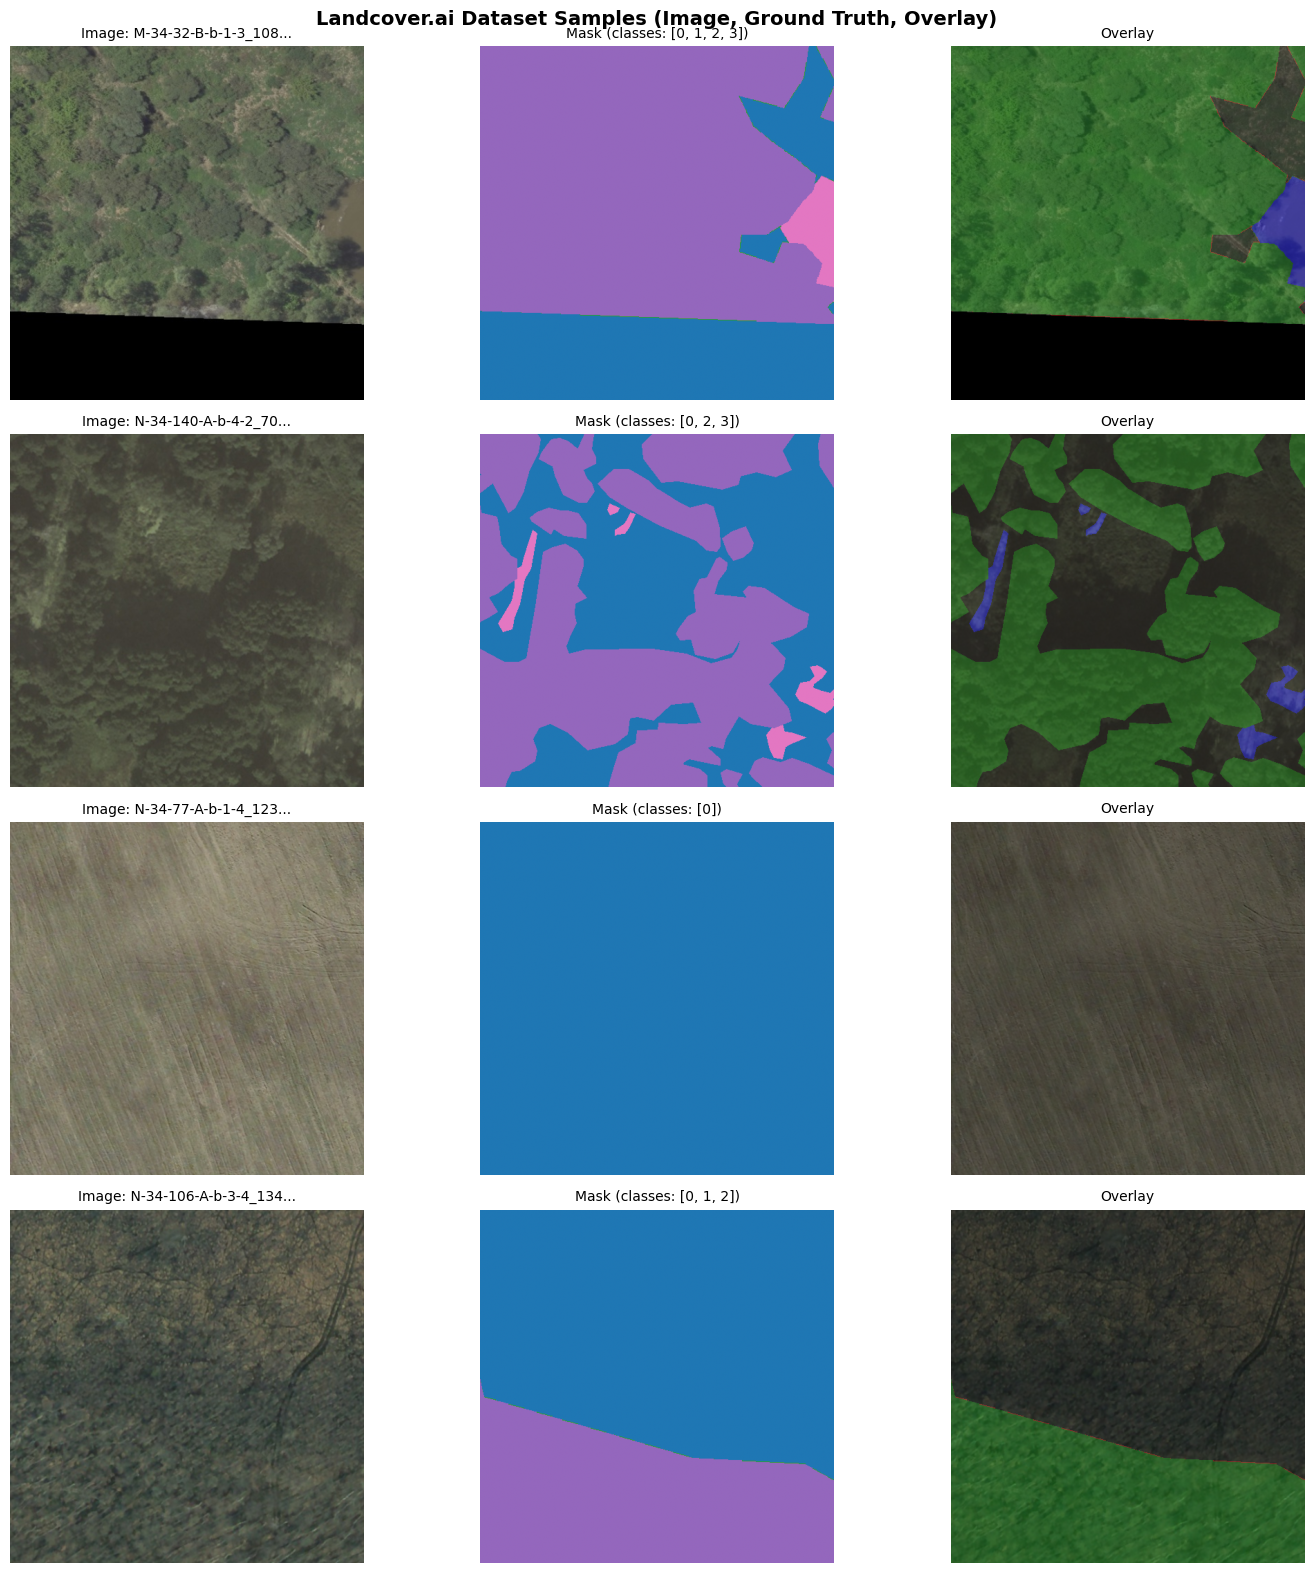

✓ Saved data_samples.png


In [5]:
print("\n=== Visualizing Samples ===\n")

# Get 4 random samples from training set
sample_indices = np.random.choice(len(train_dataset), 4, replace=False)
samples = [train_dataset[i] for i in sample_indices]

# Denormalization function (reverse ImageNet norm)
def denormalize(img):
    """Reverse ImageNet normalization."""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    img = img * std + mean
    return torch.clamp(img, 0, 1)

# Create visualization
fig, axes = plt.subplots(4, 3, figsize=(15, 16))
fig.suptitle('Landcover.ai Dataset Samples (Image, Ground Truth, Overlay)', fontsize=14, fontweight='bold')

# Class color mapping
class_colors = {
    0: [0.0, 0.0, 0.0],      # Background - black
    1: [1.0, 0.0, 0.0],      # Building - red
    2: [0.0, 0.5, 0.0],      # Woodland - dark green
    3: [0.0, 0.0, 1.0],      # Water - blue
    4: [1.0, 1.0, 0.0],      # Road - yellow
}

for row in range(len(samples)):
    img, mask = samples[row]
    tile_name = train_dataset.tile_names[sample_indices[row]]
    
    # Denormalize image
    img_denorm = denormalize(img).numpy().transpose(1, 2, 0)
    mask_np = mask.numpy()
    
    # Row 1: Original image
    axes[row, 0].imshow(img_denorm)
    axes[row, 0].set_title(f'Image: {tile_name[:25]}...', fontsize=10)
    axes[row, 0].axis('off')
    
    # Row 2: Mask
    axes[row, 1].imshow(mask_np, cmap='tab10', vmin=0, vmax=5)
    axes[row, 1].set_title(f'Mask (classes: {sorted(np.unique(mask_np).tolist())})', fontsize=10)
    axes[row, 1].axis('off')
    
    # Row 3: Overlay (mask as colored overlay on image)
    mask_rgb = np.zeros((*mask_np.shape, 3))
    for class_id, color in class_colors.items():
        mask_rgb[mask_np == class_id] = color
    
    overlay = 0.6 * img_denorm + 0.4 * mask_rgb
    axes[row, 2].imshow(overlay)
    axes[row, 2].set_title('Overlay', fontsize=10)
    axes[row, 2].axis('off')

plt.tight_layout()
plt.savefig('data_samples.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Saved data_samples.png")

## 7: Analyze Class Distribution

In [8]:
# print("\n=== Dataset Statistics ===\n")
# breakpoint()
# # Count class distribution in training set
# class_counts = {i: 0 for i in range(5)}
# total_pixels = 0

# print("Counting class distribution in first 100 training tiles...")
# for i in range(min(10000, len(train_dataset))):
#     img, mask = train_dataset[i]
#     for class_id in range(5):
#         class_counts[class_id] += (mask == class_id).sum().item()
#     total_pixels += mask.numel()
#     if (i + 1) % 25 == 0:
#         print(f"  Processed {i + 1} tiles...")

# class_names = {0: 'Background', 1: 'Building', 2: 'Woodland', 3: 'Water', 4: 'Road'}

# print(f"\nClass distribution:")
# for class_id in range(5):
#     pct = (class_counts[class_id] / total_pixels * 100) if total_pixels > 0 else 0
#     print(f"  {class_id} ({class_names[class_id]:10s}): {class_counts[class_id]:>10,} pixels ({pct:>5.1f}%)")

# print(f"\nTotal pixels sampled: {total_pixels:,}")
# print("\n✓ Data loading complete! Ready for training.")

## 8: Import TrainingSession and Loss Functions

In [6]:
# Import from project directory
sys.path.insert(0, '../../')

from models import DiceLoss, DeepLab, JaccardLoss, ResNet_UNet, SegFormer
from training_utils import TrainingSession

print("✓ Imported TrainingSession and loss functions")

a:\anaconda3\envs\machine\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Imported TrainingSession and loss functions


## 9: Create Weighted Loss Function

In [ ]:
print("\n=== Setting Up Loss Function ===\n")

"""
Class distribution:
  0 (Background): 1,134,439,928 pixels ( 57.9%)
  1 (Building  ): 16,584,602 pixels (  0.8%)
  2 (Woodland  ): 648,714,832 pixels ( 33.1%)
  3 (Water     ): 126,508,305 pixels (  6.5%)
  4 (Road      ): 31,785,377 pixels (  1.6%)
"""
background =  0.579
building   =  0.015
woodland   =  0.331
water      =  0.065
road       =  0.02
# Inverse frequency Normalized weights: ['0.0083', '0.6020', '0.0146', '0.0741', '0.3010']

# edited to balance better
# Sqrt inverse weights: ['1.3142', '11.1803', '1.7381', '3.9223', '7.9057']
class_dist = torch.tensor([background, building, woodland, water, road])
class_weights = 1.0 / torch.sqrt(class_dist)
class_weights = class_weights.to(device)

print(f"Class frequencies:  {[f'{x:.3f}' for x in class_dist.tolist()]}")
print(f"Normalized weights: {[f'{x:.4f}' for x in class_weights.tolist()]}")

# JaccardLoss combines CE + IoU + Boundary loss for better segmentation optimization
loss_fn = JaccardLoss(
    num_classes=5, 
    weight=class_weights, 
    alpha=0.3,
    boundary_weight=0.3
)


=== Setting Up Loss Function ===

Class frequencies:  ['0.579', '0.015', '0.331', '0.065', '0.020']
Normalized weights: ['1.3142', '8.1650', '1.7381', '3.9223', '7.0711']


## 10: Initialize Models

In [ ]:
print("\n=== Initializing Models ===\n")
deeplab_model = DeepLab(num_classes=5, input_image_size=512, backbone='resnet50', output_stride=4).to(device)
deeplab_params = sum(p.numel() for p in deeplab_model.parameters())
print(f"\nDeepLab:")
print(f"  Parameters: {deeplab_params:,}")
print(f"  Device: {device}")
deeplab_model.load_state_dict(torch.load('experiments/_/best_model.pth'))  # Load pretrained weights


=== Initializing Models ===


DeepLab:
  Parameters: 15,908,650
  Device: cuda


<All keys matched successfully>

## 11: Train Deeplab

In [18]:
from transformers import get_cosine_schedule_with_warmup

init_lr = 5e-5
num_epochs = 50
steps_per_epoch = len(train_loader)
num_training_steps = num_epochs * steps_per_epoch
warmup_steps = int(0.1 * num_training_steps)

optimizer = torch.optim.AdamW(
    deeplab_model.parameters(),
    lr=init_lr,
    weight_decay=0.01,
    betas=(0.9, 0.999),
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=num_training_steps,
    eta_min=0
)

deeplab_machine = TrainingSession(
    model=deeplab_model,
    trainLoader=train_loader,
    testLoader=val_loader,
    lossFunc=loss_fn,
    init_lr=init_lr,
    num_epochs=num_epochs,
    experiment_name="ResNet_UNet_Landcover_v2",
    optimizer=optimizer,
    class_names=CLASS_NAMES,
    scheduler=scheduler, # type: ignore
    amp=True
)

Using CUDA device.


In [ ]:
deeplab_machine.learn()

## 12: Evaluate DeepLab on Test Set


=== Evaluating DeepLab on Test Set ===


Test Set Results:
  Pixel Accuracy: 0.9582
  mIoU: 0.6993


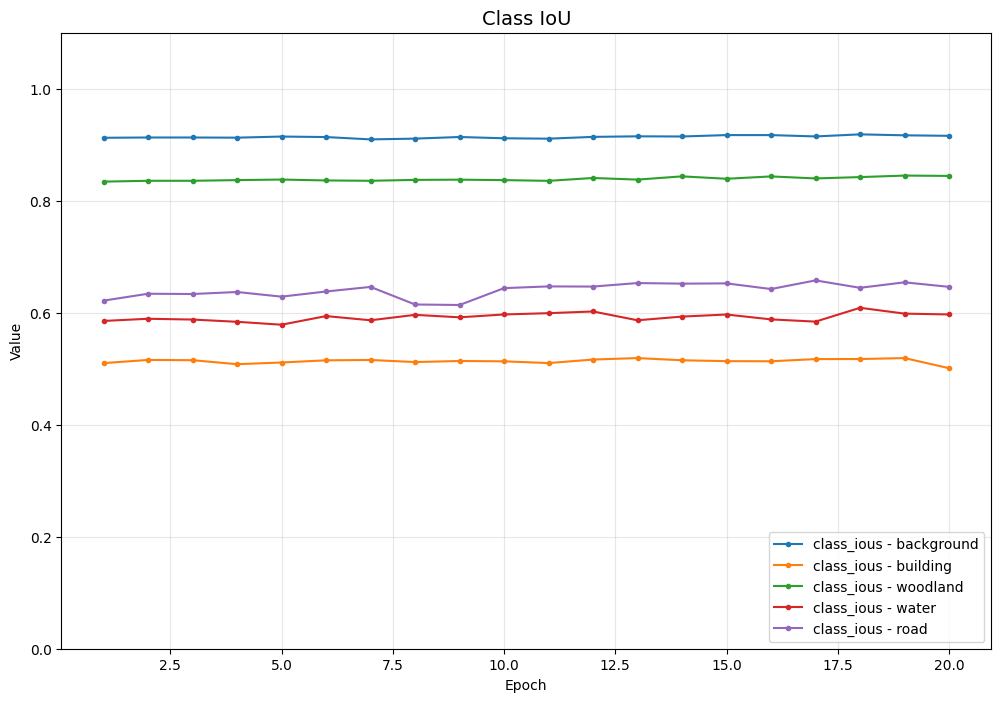

['Pixel_Accuracy', 'Precision', 'Recall', 'IoU', 'class_ious', 'class_precisions', 'class_recalls', 'Loss']


In [119]:
print("\n=== Evaluating DeepLab on Test Set ===\n")

# Run evaluation
test_metrics = deeplab_machine.evaluate(test_loader)

print(f"\nTest Set Results:")
print(f"  Pixel Accuracy: {test_metrics['Pixel_Accuracy']:.4f}")
print(f"  mIoU: {test_metrics['IoU']:.4f}")
deeplab_machine.plot_metrics("Class IoU", metrics_wanted=["class_ious"])
print(deeplab_machine.get_available_metrics())

## 13: Visualize Predictions

In [9]:
from training_utils import SegmentationDataset
import matplotlib.colors as mcolors

mangrove_path = "A:\\Drone_Data\\original_data\\512dataset_images.npy"
labels_path = "A:\\Drone_Data\\original_data\\512dataset_labels.npy"
mangrove_dataset = SegmentationDataset(mangrove_path, labels_path, transforms=v2.Compose([v2.ToImage()]), load_to_ram=False)

tab10 = plt.get_cmap("tab10")
base_colors = [tuple(map(float, tab10(i)[:3])) for i in range(5)]  # 5 classes

blue = base_colors[0]
orange = base_colors[1]
green = base_colors[2]
red = base_colors[3]
pink = base_colors[4]
gray = (0.8, 0.8, 0.8)

human_colors = [
    gray,       # class 0: background
    red,        # class 1: building
    green,      # class 2: vegetation
    blue,       # class 3: water
    pink,       # class 4: road
]

mangrove_colors = [
    gray,       # class 0: background
    green,      # class 1: undefined
]

def visualize_predictions(model,
                          dataset: Dataset,
                          indices: list[int],
                          class1_colors: list[tuple[float, float, float]],
                          class2_colors: list[tuple[float, float, float]],
                          path: str = 'predictions.png',
                          normalize: bool = True
                        ):
    channels1 = len(class1_colors)
    channels2 = len(class2_colors)

    class1_colors = mcolors.ListedColormap(class1_colors) # type: ignore
    class2_colors = mcolors.ListedColormap(class2_colors) # type: ignore


    num_predictions = len(indices)
    model.eval()
    with torch.no_grad():
        fig, axes = plt.subplots(num_predictions, 4, figsize=(20, 16))
        for row, idx in enumerate(indices):
            img, mask = dataset[idx]

            if normalize:
                # ---- Normalize ----
                img = img.float()
                if img.max() > 1.5:      # if uint8
                    img = img / 255.0
                img = (img - torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)) / torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
                
            
            img_batch = img.unsqueeze(0).float().to(device)
            
            # Get prediction
            pred = deeplab_model(img_batch)
            pred_mask = torch.argmax(pred, dim=1).squeeze().cpu().numpy()

            # ---- IMAGE FOR DISPLAY ----
            img_np = denormalize(img).numpy().transpose(1, 2, 0)

            # ---- GROUND TRUTH MASK ----
            mask_np = mask.cpu().numpy().astype(int)
            mask_np = np.squeeze(mask_np)   # (H, W)

            # ---- DRAW ----
            axes[row, 0].imshow(img_np)
            axes[row, 0].set_title("Image")
            axes[row, 0].axis("off")

            axes[row, 1].imshow(mask_np, cmap=class1_colors, vmin=0, vmax=channels1-1)
            axes[row, 1].set_title("Ground Truth")
            axes[row, 1].axis("off")

            axes[row, 2].imshow(pred_mask, cmap=class2_colors, vmin=0, vmax=channels2-1)
            axes[row, 2].set_title('Prediction', fontweight='bold')
            axes[row, 2].axis('off')

            # Overlay prediction on image
            pred_rgb = np.zeros((*pred_mask.shape, 3))
            for class_id, color in class_colors.items():
                pred_rgb[pred_mask == class_id] = color
            overlay = 0.6 * img_np + 0.4 * pred_rgb
            axes[row, 3].imshow(overlay)
            axes[row, 3].set_title('Prediction Overlay', fontweight='bold')
            axes[row, 3].axis('off')

    plt.tight_layout()
    plt.savefig(path, dpi=100, bbox_inches="tight")
    plt.show()

Selected test indices: [387, 1118, 72, 1440]


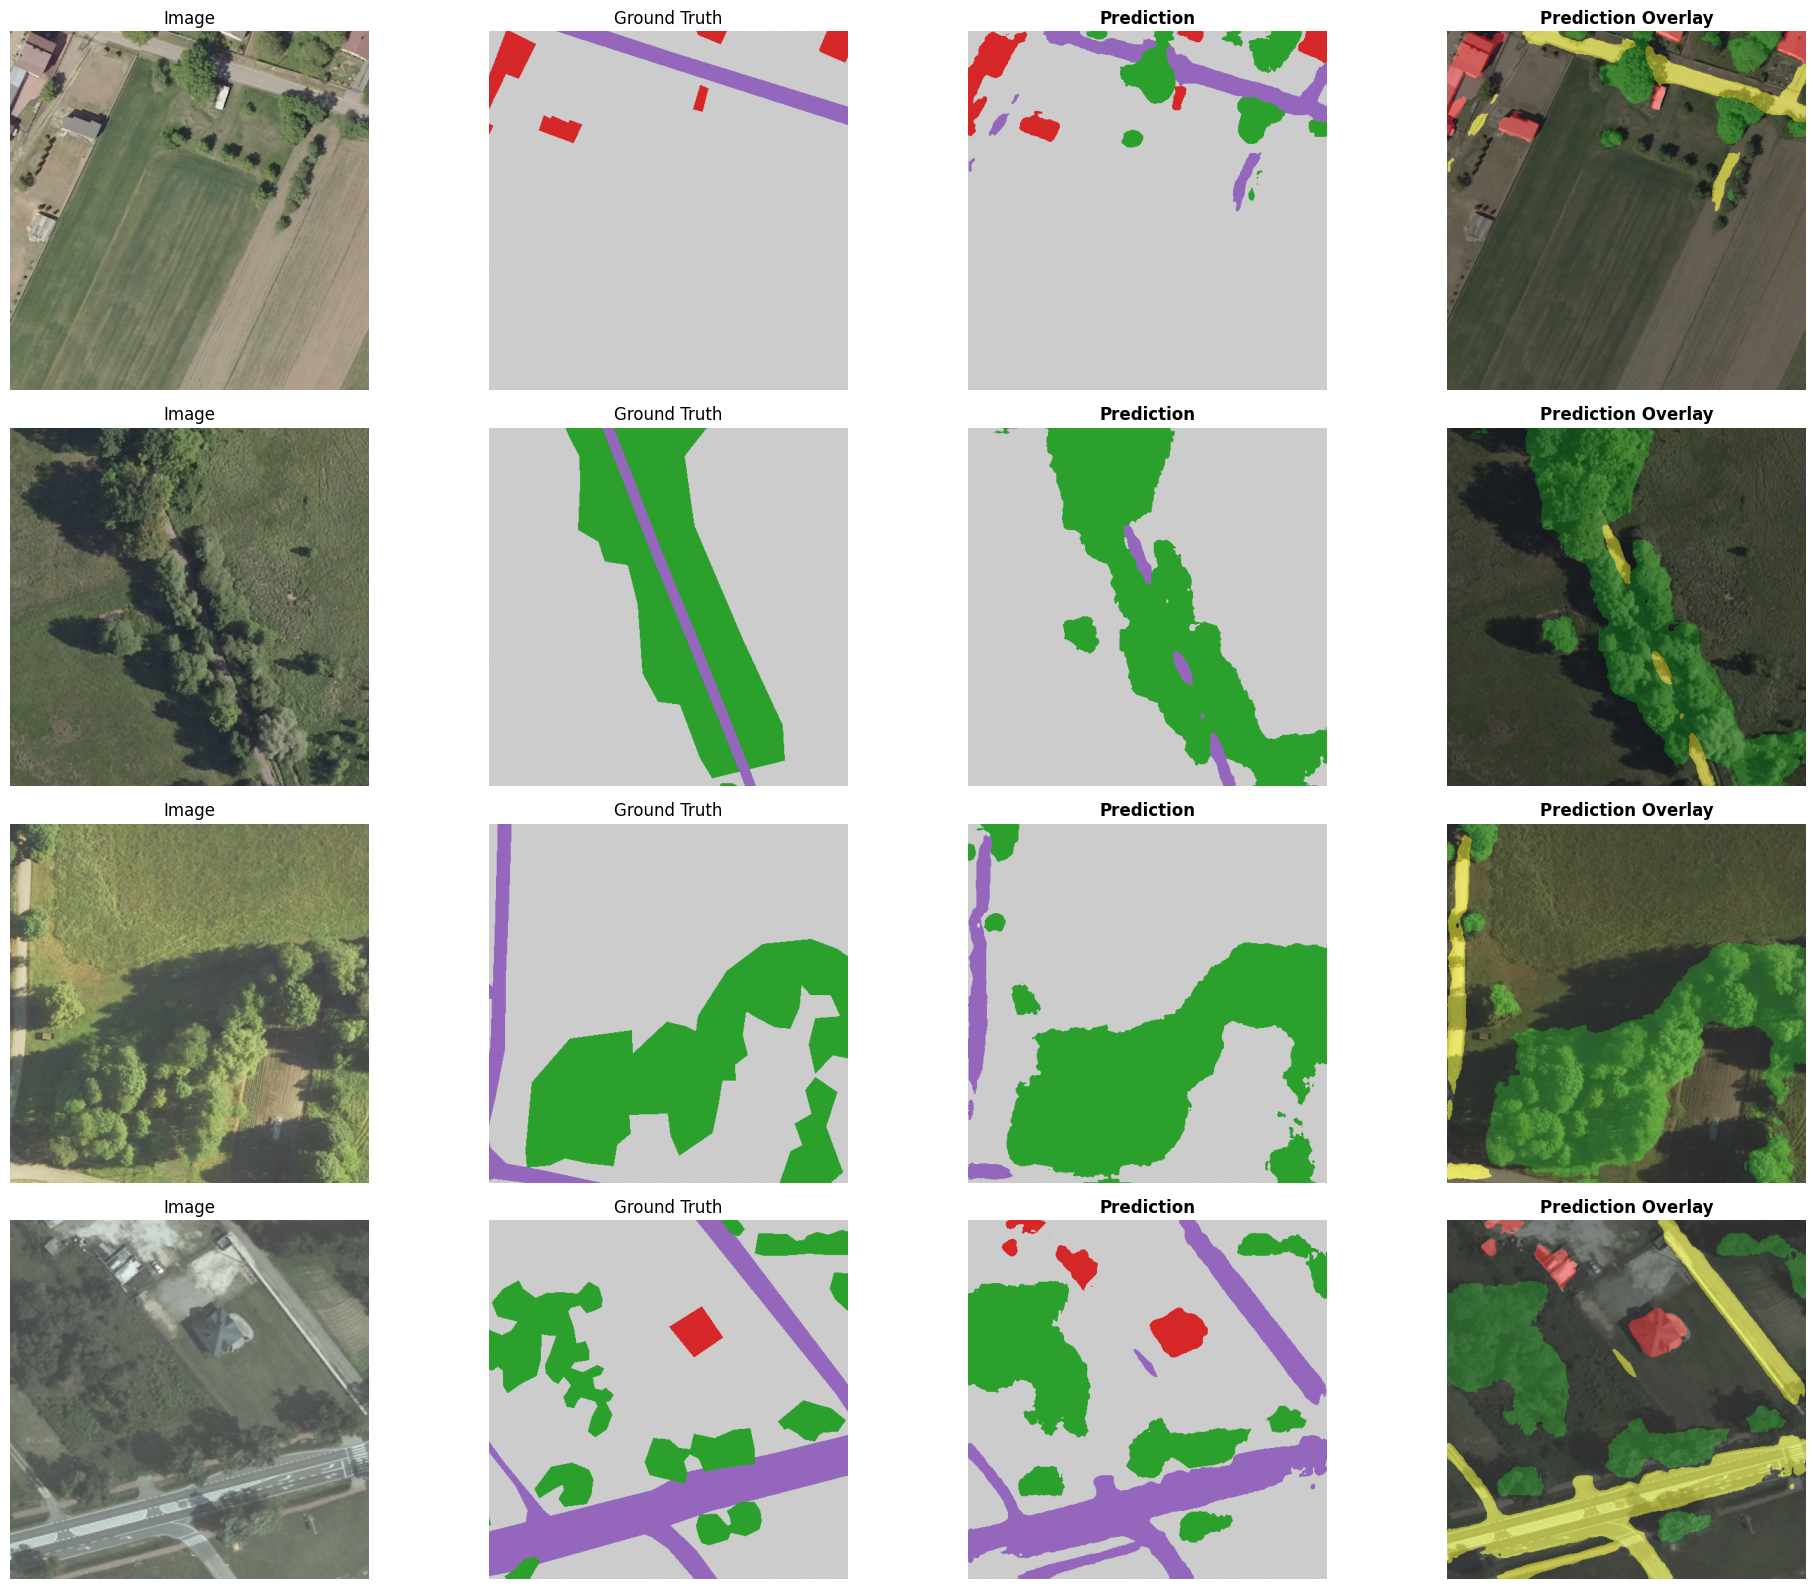

In [10]:
test_indices = [387, 1118, 72, 1440]
print(f"Selected test indices: {test_indices}")
visualize_predictions(
    deeplab_model, 
    test_dataset, 
    test_indices, 
    human_colors, 
    human_colors,
    path = "landcover_predictions.png",
    normalize = False
)

In [ ]:
test_indices = np.random.choice(len(test_dataset), 4, replace=False).tolist()
print(f"Selected test indices: {test_indices}")
visualize_predictions(
    deeplab_model, 
    mangrove_dataset, 
    test_indices, 
    mangrove_colors, 
    human_colors,
    path = "mangrove_predictions.png"
)

In [ ]:
test_indices = [47, 28990, 55215, 21071] # water and mangrove
visualize_predictions(
    deeplab_model, 
    mangrove_dataset, 
    test_indices, 
    mangrove_colors, 
    human_colors,
    path = "mangrove_water_mangrove_predictions.png"
)

In [ ]:
test_indices = [58467, 38630, 29714, 49601] # road
visualize_predictions(
    deeplab_model, 
    mangrove_dataset, 
    test_indices, 
    mangrove_colors, 
    human_colors,
    path = "mangrove_road_predictions.png"
)

In [ ]:
test_indices = [25263, 14810, 56076, 39257] # building
visualize_predictions(
    deeplab_model, 
    mangrove_dataset, 
    test_indices, 
    mangrove_colors, 
    human_colors,
    path = "mangrove_building_predictions.png"
)